In [1]:
# import required packages
from imodels import get_clean_dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusClassifier
from imodels.tree.rf_plus.feature_importance.rfplus_explainer import  AloRFPlusMDI, RFPlusLime
# from subgroup_detection import detect_subgroups, compute_rbo_matrix
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

KeyboardInterrupt: 

In [3]:
# get pre-cleaned compas dataset from imodels
X, y, feature_names = get_clean_dataset('compas_two_year_clean', data_source='imodels')
X = pd.DataFrame(X, columns=feature_names)

In [4]:
# the propublica study narrowed the dataset to only African-American and
# Caucasian defendants, and doing so keeps the vast majority of the data,
# so we will do the same.
y = y[(X['race:African-American'] == 1) | (X['race:Caucasian'] == 1)]
X = X[(X['race:African-American'] == 1) | (X['race:Caucasian'] == 1)]

# now that we have narrowed the dataset, we should remove the one-hot encodings
# of variables that are consistently zero, such as the other ethnicities.
# we also drop age because the binned 'age category' is preferred here.
X = X.drop(["race:Asian", "race:Hispanic", "race:Native_American",
            "race:Other", "age"], axis = 1)

In [5]:
X.head()

,priors_count,days_b_screening_arrest,c_jail_time,juv_fel_count,juv_other_count,juv_misd_count,c_charge_degree:F,c_charge_degree:M,race:African-American,race:Caucasian,age_cat:25_-_45,age_cat:Greater_than_45,age_cat:Less_than_25,sex:Female,sex:Male
1,0.0,-1.0,10.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,4.0,-1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,14.0,-1.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
6,0.0,-1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
7,0.0,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [5]:
# split data into training and testing sets
# we won't actually use the test set here though, since 'discovery' would be
# a post-hoc analysis in real life
# proportion of training data is small so rf+ can fit without taking hours
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

In [6]:
print("Total Proportion of Recidivism:", y.mean())
print("Proportion of Recidivism in Training Data:", y_train.mean())
print("Total Proportion of African-American Defendants:",
      X["race:African-American"].mean())
print("Proportion of African-American Defendants in Training Data:",
      X_train["race:African-American"].mean())
print("Total Proportion of Caucasian Defendants:",
      X["race:Caucasian"].mean())
print("Proportion of Caucasian Defendants in Training Data:",
      X_train["race:Caucasian"].mean())
print("Total Proportion of Male Defendants:",
      X["sex:Male"].mean())
print("Proportion of Male Defendants in Training Data:",
      X_train["sex:Male"].mean())
print("Total Proportion of Female Defendants:",
      X["sex:Female"].mean())
print("Proportion of Female Defendants in Training Data:",
      X_train["sex:Female"].mean())

Total Proportion of Recidivism: 0.5015157256536567
Proportion of Recidivism in Training Data: 0.5064970221981592
Total Proportion of African-American Defendants: 0.6015536
Proportion of African-American Defendants in Training Data: 0.5979968
Total Proportion of Caucasian Defendants: 0.39844638
Proportion of Caucasian Defendants in Training Data: 0.40200326
Total Proportion of Male Defendants: 0.80466086
Proportion of Male Defendants in Training Data: 0.80915
Total Proportion of Female Defendants: 0.19533914
Proportion of Female Defendants in Training Data: 0.19085003


In [8]:
# fit RF+ model
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf_plus = RandomForestPlusClassifier(rf)
rf_plus.fit(X_train, y_train)
y_pred = rf_plus.predict(X_test)

# compute accuracy on the test set
accuracy = np.mean(y_pred == y_test)
misclassified = np.sum(y_pred != y_test)

print(f'RF+ Test Set Accuracy: {accuracy}')
print(f'RF+ Test Set # Misclassified: {misclassified}')
print(f'RF+ Test Set # of Points: {y_test.shape[0]}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 16.6min finished


RF+ Test Set Accuracy: 0.6167929292929293
RF+ Test Set # Misclassified: 607
RF+ Test Set # of Points: 1584


In [9]:
# fit RF+ model
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X, y)
rf_plus = RandomForestPlusClassifier(rf)
rf_plus.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 31.7min finished


In [10]:
# get feature importances
mdi_explainer = AloRFPlusMDI(rf_plus, evaluate_on='oob')
mdi, partial_preds = mdi_explainer.explain(np.asarray(X), y)
mdi_rankings = mdi_explainer.get_rankings(mdi)

In [14]:
X.columns

Index(['priors_count', 'days_b_screening_arrest', 'c_jail_time',
       'juv_fel_count', 'juv_other_count', 'juv_misd_count',
       'c_charge_degree:F', 'c_charge_degree:M', 'race:African-American',
       'race:Caucasian', 'age_cat:25_-_45', 'age_cat:Greater_than_45',
       'age_cat:Less_than_25', 'sex:Female', 'sex:Male'],
      dtype='object')

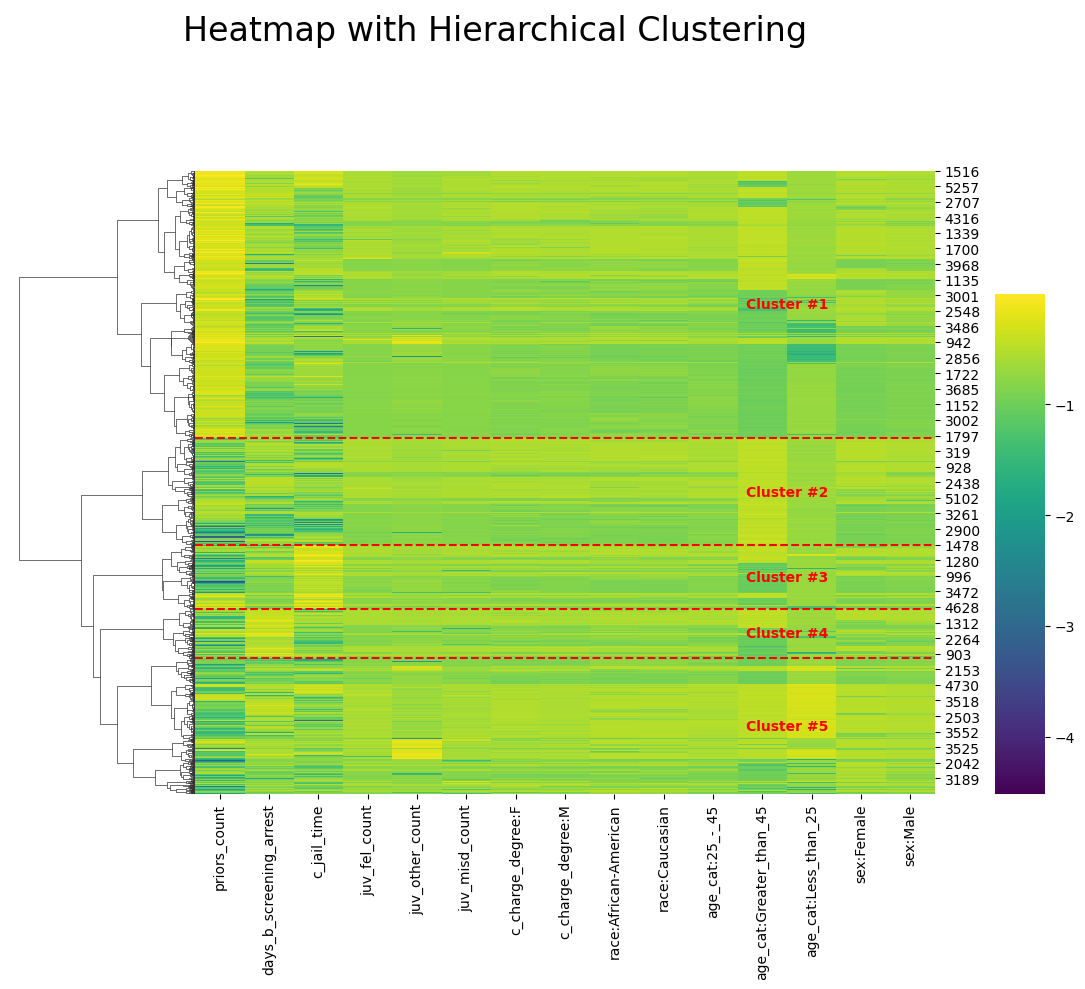

In [23]:
mdi_copy = pd.DataFrame(mdi, columns=X.columns).copy()
num_clusters = 5
clusters = detect_subgroups(mdi_copy, mdi_rankings, num_clusters)

In [24]:
X['cluster'] = clusters

# split each cluster into its own set
cluster1X = X[X['cluster']==1]
cluster2X = X[X['cluster']==2]
cluster3X = X[X['cluster']==3]
cluster4X = X[X['cluster']==4]
cluster5X = X[X['cluster']==5]
cluster1y = y[X['cluster']==1]
cluster2y = y[X['cluster']==2]
cluster3y = y[X['cluster']==3]
cluster4y = y[X['cluster']==4]
cluster5y = y[X['cluster']==5]

# remove cluster column from cluster X's
cluster1X = cluster1X.drop(columns='cluster')
cluster2X = cluster2X.drop(columns='cluster')
cluster3X = cluster3X.drop(columns='cluster')
cluster4X = cluster4X.drop(columns='cluster')
cluster5X = cluster5X.drop(columns='cluster')
X = X.drop(columns='cluster')

# split each cluster into train/test
cluster1_trainX, cluster1_testX, cluster1_trainy, cluster1_testy = \
    train_test_split(cluster1X, cluster1y, test_size=0.3, random_state=0)
cluster2_trainX, cluster2_testX, cluster2_trainy, cluster2_testy = \
    train_test_split(cluster2X, cluster2y, test_size=0.3, random_state=1)
cluster3_trainX, cluster3_testX, cluster3_trainy, cluster3_testy = \
    train_test_split(cluster3X, cluster3y, test_size=0.3, random_state=1)
cluster4_trainX, cluster4_testX, cluster4_trainy, cluster4_testy = \
    train_test_split(cluster4X, cluster4y, test_size=0.3, random_state=1)
cluster5_trainX, cluster5_testX, cluster5_trainy, cluster5_testy = \
    train_test_split(cluster5X, cluster5y, test_size=0.3, random_state=1)

In [25]:
# fit RF+ on each training set, predict test
rf1 = RandomForestClassifier(n_estimators=100, random_state=0)
rf_plus1 = RandomForestPlusClassifier(rf1)
rf_plus1.fit(cluster1_trainX, cluster1_trainy)

rf2 = RandomForestClassifier(n_estimators=100, random_state=0)
rf_plus2 = RandomForestPlusClassifier(rf2)
rf_plus2.fit(cluster2_trainX, cluster2_trainy)

rf3 = RandomForestClassifier(n_estimators=100, random_state=0)
rf_plus3 = RandomForestPlusClassifier(rf3)
rf_plus3.fit(cluster3_trainX, cluster3_trainy)

rf4 = RandomForestClassifier(n_estimators=100, random_state=0)
rf_plus4 = RandomForestPlusClassifier(rf4)
rf_plus4.fit(cluster4_trainX, cluster4_trainy)

rf5 = RandomForestClassifier(n_estimators=100, random_state=0)
rf_plus5 = RandomForestPlusClassifier(rf5)
rf_plus5.fit(cluster5_trainX, cluster5_trainy)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/errors.py:66: RuntimeWarning: Model did not converge for smaller values of lambda, returning solution for the largest 100 values.
  warnings.warn("Model did not converge for smaller values of lambda, "
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/errors.py:66: RuntimeWarning: Model did not converge for smaller values of lambd

In [26]:
print("---------------------------------------------")
y_pred = rf_plus1.predict(cluster1_testX)
mis1 = np.sum(cluster1_testy != y_pred)
print(f'RF+ Cluster #1 Test Set # of Points: {cluster1_testy.shape[0]}')
print(f'RF+ Cluster #1 Test Set # Misclassified: {mis1}')
print("---------------------------------------------")
y_pred = rf_plus1.predict(cluster2_testX)
mis2 = np.sum(cluster2_testy != y_pred)
print(f'RF+ Cluster #2 Test Set # of Points: {cluster2_testy.shape[0]}')
print(f'RF+ Cluster #2 Test Set # Misclassified: {mis2}')
print("---------------------------------------------")
y_pred = rf_plus3.predict(cluster3_testX)
mis3 = np.sum(cluster3_testy != y_pred)
print(f'RF+ Cluster #3 Test Set # of Points: {cluster3_testy.shape[0]}')
print(f'RF+ Cluster #3 Test Set # Misclassified: {mis3}')
print("---------------------------------------------")
y_pred = rf_plus4.predict(cluster4_testX)
mis4 = np.sum(cluster4_testy != y_pred)
print(f'RF+ Cluster #4 Test Set # of Points: {cluster4_testy.shape[0]}')
print(f'RF+ Cluster #4 Test Set # Misclassified: {mis4}')
print("---------------------------------------------")
y_pred = rf_plus5.predict(cluster5_testX)
mis5 = np.sum(cluster5_testy != y_pred)
print(f'RF+ Cluster #5 Test Set # of Points: {cluster5_testy.shape[0]}')
print(f'RF+ Cluster #5 Test Set # Misclassified: {mis5}')
print("---------------------------------------------")

---------------------------------------------
RF+ Cluster #1 Test Set # of Points: 680
RF+ Cluster #1 Test Set # Misclassified: 2
---------------------------------------------
RF+ Cluster #2 Test Set # of Points: 274
RF+ Cluster #2 Test Set # Misclassified: 167
---------------------------------------------
RF+ Cluster #3 Test Set # of Points: 162
RF+ Cluster #3 Test Set # Misclassified: 11
---------------------------------------------
RF+ Cluster #4 Test Set # of Points: 126
RF+ Cluster #4 Test Set # Misclassified: 5
---------------------------------------------
RF+ Cluster #5 Test Set # of Points: 345
RF+ Cluster #5 Test Set # Misclassified: 35
---------------------------------------------


In [28]:
print("---------------------------------------------")
print("Total # of Observations Predicted by Global Model:", X_test.shape[0])
print("Total # of Observations Predicted by Cluster Models:",
      cluster1_testX.shape[0] + cluster2_testX.shape[0] + cluster3_testX.shape[0] + cluster4_testX.shape[0] + cluster5_testX.shape[0])
print("---------------------------------------------")
print("Difference in # Misclassified (Global - Sum of Clusters):", round(misclassified - (mis1 + mis2 + mis3 + mis4 + mis5), 2))
print(f"Percent Improvement Over Global Model: {round(100*(misclassified - (mis1 + mis2 + mis3 + mis4 + mis5))/misclassified, 2)}%")
print("---------------------------------------------")

---------------------------------------------
Total # of Observations Predicted by Global Model: 1584
Total # of Observations Predicted by Cluster Models: 1587
---------------------------------------------
Difference in # Misclassified (Global - Sum of Clusters): 387
Percent Improvement Over Global Model: 63.76%
---------------------------------------------


In [31]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = np.abs(explainer.shap_values(X, check_additivity=False))

In [ ]:
shap_rankings = mdi_explainer.get_rankings(shap_values)

In [ ]:
shap_copy = pd.DataFrame(shap_values, columns=X.columns).copy()
num_clusters = 5
clusters = detect_subgroups(shap_copy, shap_rankings, num_clusters)

In [ ]:
# split each cluster into its own set
cluster1X = X[X['cluster']==1]
cluster2X = X[X['cluster']==2]
cluster3X = X[X['cluster']==3]
cluster4X = X[X['cluster']==4]
cluster5X = X[X['cluster']==5]
# cluster6X = X[X['cluster']==6]
# cluster7X = X[X['cluster']==7]
# cluster8X = X[X['cluster']==8]
cluster1y = y[X['cluster']==1]
cluster2y = y[X['cluster']==2]
cluster3y = y[X['cluster']==3]
cluster4y = y[X['cluster']==4]
cluster5y = y[X['cluster']==5]
# cluster6y = y[X['cluster']==6]
# cluster7y = y[X['cluster']==7]
# cluster8y = y[X['cluster']==8]

# remove cluster column from cluster X's
cluster1X = cluster1X.drop(columns='cluster')
cluster2X = cluster2X.drop(columns='cluster')
cluster3X = cluster3X.drop(columns='cluster')
cluster4X = cluster4X.drop(columns='cluster')
cluster5X = cluster5X.drop(columns='cluster')
# cluster6X = cluster6X.drop(columns='cluster')
# cluster7X = cluster7X.drop(columns='cluster')
# cluster8X = cluster8X.drop(columns='cluster')

# split each cluster into train/test
cluster1_trainX, cluster1_testX, cluster1_trainy, cluster1_testy = \
    train_test_split(cluster1X, cluster1y, test_size=0.3, random_state=0)
cluster2_trainX, cluster2_testX, cluster2_trainy, cluster2_testy = \
    train_test_split(cluster2X, cluster2y, test_size=0.3, random_state=1)
cluster3_trainX, cluster3_testX, cluster3_trainy, cluster3_testy = \
    train_test_split(cluster3X, cluster3y, test_size=0.3, random_state=0)
cluster4_trainX, cluster4_testX, cluster4_trainy, cluster4_testy = \
    train_test_split(cluster4X, cluster4y, test_size=0.3, random_state=0)
cluster5_trainX, cluster5_testX, cluster5_trainy, cluster5_testy = \
    train_test_split(cluster5X, cluster5y, test_size=0.3, random_state=0)
# cluster6_trainX, cluster6_testX, cluster6_trainy, cluster6_testy = \
#     train_test_split(cluster6X, cluster6y, test_size=0.3, random_state=1)
# cluster7_trainX, cluster7_testX, cluster7_trainy, cluster7_testy = \
#     train_test_split(cluster7X, cluster7y, test_size=0.3, random_state=0)
# cluster8_trainX, cluster8_testX, cluster8_trainy, cluster8_testy = \
#     train_test_split(cluster8X, cluster8y, test_size=0.3, random_state=0)

In [ ]:
# fit RF+ on each training set, predict test
rf1 = RandomForestRegressor(n_estimators=100, random_state=0)
rf_plus1 = RandomForestPlusRegressor(rf1)
rf_plus1.fit(cluster1_trainX, cluster1_trainy)

rf2 = RandomForestRegressor(n_estimators=100, random_state=0)
rf_plus2 = RandomForestPlusRegressor(rf2)
rf_plus2.fit(cluster2_trainX, cluster2_trainy)

rf3 = RandomForestRegressor(n_estimators=100, random_state=0)
rf_plus3 = RandomForestPlusRegressor(rf3)
rf_plus3.fit(cluster3_trainX, cluster3_trainy)

rf4 = RandomForestRegressor(n_estimators=100, random_state=0)
rf_plus4 = RandomForestPlusRegressor(rf4)
rf_plus4.fit(cluster4_trainX, cluster4_trainy)

rf5 = RandomForestRegressor(n_estimators=100, random_state=0)
rf_plus5 = RandomForestPlusRegressor(rf5)
rf_plus5.fit(cluster5_trainX, cluster5_trainy)

# rf6 = RandomForestRegressor(n_estimators=100, random_state=0)
# rf_plus6 = RandomForestPlusRegressor(rf6)
# rf_plus6.fit(cluster6_trainX, cluster6_trainy)

# rf7 = RandomForestRegressor(n_estimators=100, random_state=0)
# rf_plus7 = RandomForestPlusRegressor(rf7)
# rf_plus7.fit(cluster7_trainX, cluster7_trainy)

# rf8 = RandomForestRegressor(n_estimators=100, random_state=0)
# rf_plus8 = RandomForestPlusRegressor(rf8)
# rf_plus8.fit(cluster8_trainX, cluster8_trainy)

In [ ]:
# compute r^2 on the test set
print("---------------------------------------------")
y_pred = rf_plus1.predict(cluster1_testX)
r2 = r2_score(cluster1_testy, y_pred)
tse1 = np.sum((cluster1_testy - y_pred)**2)
print(f'RF+ Cluster #1 Test Set R^2: {r2}')
print(f'RF+ Cluster #1 Test Set TSE: {tse1}')
print("---------------------------------------------")
y_pred = rf_plus2.predict(cluster2_testX)
r2 = r2_score(cluster2_testy, y_pred)
tse2 = np.sum((cluster2_testy - y_pred)**2)
print(f'RF+ Cluster #2 Test Set R^2: {r2}')
print(f'RF+ Cluster #2 Test Set TSE: {tse2}')
print("---------------------------------------------")
y_pred = rf_plus3.predict(cluster3_testX)
r2 = r2_score(cluster3_testy, y_pred)
tse3 = np.sum((cluster3_testy - y_pred)**2)
print(f'RF+ Cluster #3 Test Set R^2: {r2}')
print(f'RF+ Cluster #3 Test Set TSE: {tse3}')
print("---------------------------------------------")
y_pred = rf_plus4.predict(cluster4_testX)
r2 = r2_score(cluster4_testy, y_pred)
tse4 = np.sum((cluster4_testy - y_pred)**2)
print(f'RF+ Cluster #4 Test Set R^2: {r2}')
print(f'RF+ Cluster #4 Test Set TSE: {tse4}')
print("---------------------------------------------")
y_pred = rf_plus5.predict(cluster5_testX)
r2 = r2_score(cluster5_testy, y_pred)
tse5 = np.sum((cluster5_testy - y_pred)**2)
print(f'RF+ Cluster #5 Test Set R^2: {r2}')
print(f'RF+ Cluster #5 Test Set TSE: {tse5}')
print("---------------------------------------------")
# y_pred = rf_plus6.predict(cluster6_testX)
# r2 = r2_score(cluster6_testy, y_pred)
# tse6 = np.sum((cluster6_testy - y_pred)**2)
# print(f'RF+ Cluster #6 Test Set R^2: {r2}')
# print(f'RF+ Cluster #6 Test Set TSE: {tse6}')
# print("---------------------------------------------")
# y_pred = rf_plus7.predict(cluster7_testX)
# r2 = r2_score(cluster7_testy, y_pred)
# tse7 = np.sum((cluster7_testy - y_pred)**2)
# print(f'RF+ Cluster #7 Test Set R^2: {r2}')
# print(f'RF+ Cluster #7 Test Set TSE: {tse7}')
# print("---------------------------------------------")
# y_pred = rf_plus8.predict(cluster8_testX)
# r2 = r2_score(cluster8_testy, y_pred)
# tse8 = np.sum((cluster8_testy - y_pred)**2)
# print(f'RF+ Cluster #8 Test Set R^2: {r2}')
# print(f'RF+ Cluster #8 Test Set TSE: {tse8}')
# print("---------------------------------------------")

In [ ]:
print("---------------------------------------------")
print("Total # of Observations Predicted by Global Model:", X_test.shape[0])
print("Total # of Observations Predicted by Cluster Models:",
      cluster1_testX.shape[0] + cluster2_testX.shape[0] + \
          cluster3_testX.shape[0] + cluster4_testX.shape[0] + \
              cluster5_testX.shape[0])
print("---------------------------------------------")
print("Difference in TSE (Global - Sum of Clusters):", round(tse - (tse1 + tse2 + tse3 + tse4 + tse5), 2))
print(f"Percent Improvement Over Global Model: {round(100*(tse - (tse1 + tse2 + tse3 + tse4 + tse5))/tse, 2)}%")
print("---------------------------------------------")